# GPT2 experiments. 

Having tried the LSTM, and gotten mixed success, let's see if we can get GPT2 to run on my setup. Rather than repeat the problems with the LSTM, though, I'm going to only use the source data with source code removed. If GTP2 works well with that set, we can dial the difficultly up by running against the source-code-included version, but let's not start with the hard part first. 

I'm going to be doing this all following the tutorial on fastai at https://docs.fast.ai/tutorial.transformers.html

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from fastai.text.all import *
import os
from sklearn.model_selection import train_test_split
import re

In [2]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [3]:
# this is the path to the version with source code snippets removed as well as I could
base_dir = Path("/home/g-clef/local_ml_data_copy/ti-reports/1655302d-a401-4d87-a223-dbb06648bb8f")

In [4]:
# the data is stored not in a csv, like pandas wants, but in a series of text files. have to read those in by hand to make pandas dataframe
values = list()
for entry in os.listdir(base_dir):
    if entry.endswith(".txt"):
        with open(os.path.join(base_dir, entry)) as infile:
            values.append(infile.read())
df = pd.DataFrame(data=values, columns=["text"])

In [5]:
# tutorial talks about making this tokenizer so that we can use the HuggingFace tokenizer within fastai, rather than the built-in one     
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [6]:
# we then split the set of entries into a training set and a validation set, using first 90% of data. We then concatenate them back together 
# again to use the fastai splits. This seems redundant, but what I'm concerned about is the text reader pulling a biased sample of reports
# when it reads off disk (later ones last, particular vendors first, etc), so I want the train_test_split to randomly choose the 
# members of the train and valid sets, then I reformat that to use the `splits` feature in fastai
train, valid = train_test_split(df, test_size=0.1, random_state=42)
all_texts = np.concatenate([train['text'].values, valid['text'].values])
splits = [range_of(train), list(range(len(train), len(all_texts)))]
# tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [7]:
# training with a batch size of 4, and a sequence size of 256 (gpt2 used 1024 sequence length) to get this to fit on my GPU. That will make 
# things go slower, but that's okay.
bs,sl = 4,256
# dls = tls.dataloaders(bs=bs, seq_len=sl)

In [8]:
# this is a glue function to make the response of  the huggingface model fit inside the fastai library. Huggingface models return
# a tuple for predictions of (prediction, additional_activations). Fastai jsut wants a predition, so we need to drop the activations.
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [9]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

Token indices sequence length is longer than the specified maximum sequence length for this model (16033 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [11]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [12]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [15]:
learn.validate()

(#2) [2.701354503631592,14.899900436401367]

SuggestedLRs(valley=9.120108734350652e-05)

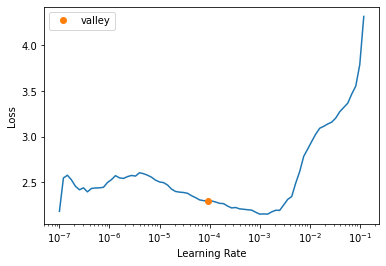

In [16]:
learn.lr_find()

This worked, and looks good from a perplexity point of view (the second number in `learn.validate`, but it's worth noting that the original way was *slow*. (the `validate` method took over an hour to run). The GPU was barely used, but one core of hte CPU was maxed out. I think what's happening is the TransformerTokenizer above is doing a lot of work, and that's all happening on the CPU, so the GPU is waiting for the CPU to repeatedly re-tokenize batches before running them. 

The tutorial mentioned another way to tokenize the text, which is to do it all at once, and only use the tranform to decode the output tensors (the results from a huggingface model) back to readable texts. That's what the `tokenize` and lower `transformersTokenizer` method are about.

In [13]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,2.022082,1.879266,6.548698,1:09:16


In [14]:
learn.save("fine-tuned")

Path('models/fine-tuned.pth')

Note: at this point I ran into a lot of problems if I left the notebook running and proceeding from here. So, I ended up saving & shutting down the notebook, then re-starting and re-loading to start here. (errors like CUDA assertion errors, unusual errors about tensor sizes not matching.  

In [16]:
learn = learn.load("fine-tuned")
learn.model = learn.to("cuda")

In [33]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 5])

In [34]:
preds = learn.model.generate(inp, max_length=100, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [35]:
tokenizer.decode(preds[0].cpu().numpy())

'\n checkerboard spider\n                                                                                              '

Well, that's weird. It looks like there's nothing there. I wonder if the training data got somehow blanked out in the transformations.

In [12]:
tokenized[0]

tensor([ 198,  220,  220,  ...,   14, 2091,  198])

In [13]:
tokenized[1]

tensor([ 198,  220,  220,  ...,   14, 1065,  198])

In [14]:
len(tokenized[0])

16033

In [15]:
len(tokenized[1])

7656

No, it looks like the tokenized values are all still there. 

In [21]:
preds[0]

tensor([50256,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220, 

In [24]:
tokenizer.decode([220])

' '

Oh, weird. It's learned nothing but spaces. I wonder why?

In [25]:
tokenizer.decode(tokenized[0])

'\n    5/7/2021                                          Operation TunnelSnake | Securelist\n\n\n        Operation    TunnelSnake\n\n\n          securelist.com/operation-tunnelsnake-and-moriya-rootkit/101831\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n        Formerly  unknown  rootkit used to secretly control networks of regional organizations\n\n\n\n\n\n    https://securelist.com/operation-tunnelsnake-and-moriya-rootkit/101831/                                   1/33\n    5/7/2021                                          Operation TunnelSnake | Securelist\n\n\n\n        Windows rootkits, especially those operating in kernel space, are pieces of malware infamous for their near absolute power in the\n        operating system. Usually deployed as drivers, such implants have high privileges in the system, allowing them to intercept and\n        potentially tamper with core I/O operations conducted by the underlying OS, like reading or writing to files or processing incomi

In [27]:
len(preds[0])

1000

So it created a proper-length thing, but put the end-of-text indicator right at the beginning, and all spaces after that. weird. 

In [28]:
tokenizer.decode(tokenized[0][:1000])

'\n    5/7/2021                                          Operation TunnelSnake | Securelist\n\n\n        Operation    TunnelSnake\n\n\n          securelist.com/operation-tunnelsnake-and-moriya-rootkit/101831\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n        Formerly  unknown  rootkit used to secretly control networks of regional organizations\n\n\n\n\n\n    https://securelist.com/operation-tunnelsnake-and-moriya-rootkit/101831/                                   1/33\n    5/7/2021                                          Operation TunnelSnake | Securelist\n\n\n\n        Windows rootkits, especially those operating in kernel space, are pieces of malware infamous for their near absolute power in the\n        operating system. Usually deployed as drivers, such implants have high privileges in the system, allowing them to intercept and\n        potentially tamper with core I/O operations conducted by the underlying OS, like reading or writing to files or processing incomi

It's true that a lot of the early characters here are spaces, so that part isn't *wrong* per-se, but why is it putting the <endoftext> token right at the beginning? So strange. In any case, it looks like it's tokenizing properly...those are valid tensors, it decodes back to what it was supposed to be. It's just the generation that's busted. Why?
    
Let's try a prompt that's just a minor modification of an existing one:

In [29]:
prompt = "1/17/2022                                          Operation Underpants Gnomes"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
inp.shape

torch.Size([1, 52])

In [30]:
preds = learn.model.generate(None, min_length=1000, max_length=1000, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [31]:
tokenizer.decode(preds[0].cpu().numpy())

'<|endoftext|>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [32]:
len(preds[0])

1000

In [33]:
preds[0]

tensor([50256,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
          220,   220,   220,   220,   220,   220,   220,   220, 

Ugh. Apparently GPT2 is looking for `<|startoftext|>` and `<|endoftext|>` markers on every sample in training, so it believes it was trained with a bunch of empty data. Need to re-read the initial input all over again, and add those tags into the text. 

(source: https://towardsdatascience.com/how-to-fine-tune-gpt-2-so-you-can-generate-long-form-creative-writing-7a5ae1314a61)

In [34]:
values = list()
for entry in os.listdir(base_dir):
    if entry.endswith(".txt"):
        with open(os.path.join(base_dir, entry)) as infile:
            data = "<|startoftext|>" + infile.read() + "<|endoftext|>"
            values.append(data)
df = pd.DataFrame(data=values, columns=["text"])

In [35]:
train, valid = train_test_split(df, test_size=0.1, random_state=42)
all_texts = np.concatenate([train['text'].values, valid['text'].values])
splits = [range_of(train), list(range(len(train), len(all_texts)))]

In [12]:
bs,sl = 4,256

In [9]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [38]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [8]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [40]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [41]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

SuggestedLRs(valley=6.30957365501672e-05)

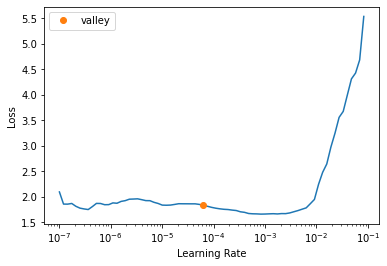

In [42]:
learn.lr_find()

In [43]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,1.919942,1.863471,6.446073,1:09:41


In [44]:
learn.save("better-fine-tuned")

Path('models/better-fine-tuned.pth')

In [54]:
prompt = "<|startoftext|>\n Checkerboard spider \n "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
inp.shape

torch.Size([1, 15])

In [55]:
preds = learn.model.generate(inp.cuda(), min_length=1000, max_length=1000, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [56]:
tokenizer.decode(preds[0].cpu().numpy())

'<|startoftext|>\n Checkerboard spider \n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [53]:
preds

tensor([[  198,  6822,   263,  3526, 19230,   220,   198,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,   220,   220,   220,   220,
           220,   220,   220,   220,   220,   220,  

In [12]:
tokenized[0]

tensor([ 198,  220,  220,  ...,   14, 2091,  198])

In [14]:
dls.show_batch(max_n=2)

,text,text_
0,"\n\n\n\n MuddyWater: Binder Project (Part 1)\n\n marcoramilli.com/2021/05/01/muddywater-binder-project-part-1/\n View all posts by marcoramilli May 1, 2021\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n According to Lab Dookhtegan, which you migth remeber him/their from HERE, HERE and HERE, Binder is a project\n related to IRGC cyber espionage group build for trojenize google apps (APK). The application “trojenization” is a well-\n known process which takes as input a good APK and a code to inject (a RAT, for example). The system is able to\n","\n\n MuddyWater: Binder Project (Part 1)\n\n marcoramilli.com/2021/05/01/muddywater-binder-project-part-1/\n View all posts by marcoramilli May 1, 2021\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n According to Lab Dookhtegan, which you migth remeber him/their from HERE, HERE and HERE, Binder is a project\n related to IRGC cyber espionage group build for trojenize google apps (APK). The application “trojenization” is a well-\n known process which takes as input a good APK and a code to inject (a RAT, for example). The system is able to\n"
1,– Service\n Execution\n Regedit regedit shell regedit reg T102,– Service\n Execution\n Regedit regedit shell regedit reg T102 –


Even trying the GPT2 tutorial data only gets us two more words, instead of the normal several. I wonder if the massive number of `\n`'s is confusing it, and leading it to predict only spaces and newlines. Will re-parse at reading, but if that's true, will want a clean dataset for later. 

I've also read a comment where adding spaces or other whitespace characters at the end of your prompt causes problems. Keep that in mind for later.

In [37]:
# read the data like before, but replace paired \n's with a single space. 
values = list()
for entry in os.listdir(base_dir):
    if entry.endswith(".txt"):
        with open(os.path.join(base_dir, entry)) as infile:
            data = infile.read()
            data.replace("\n\n", " ")
            values.append(data)
df = pd.DataFrame(data=values, columns=["text"])

In [38]:
train, valid = train_test_split(df, test_size=0.1, random_state=42)
all_texts = np.concatenate([train['text'].values, valid['text'].values])
splits = [range_of(train), list(range(len(train), len(all_texts)))]

In [39]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [40]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [41]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [42]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,1.767524,1.861074,6.430640,1:09:41


In [43]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 5])

In [44]:
preds = learn.model.generate(inp, max_length=100, num_beams=5, temperature=1.5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [45]:
tokenizer.decode(preds[0].cpu().numpy())

'\n checkerboard spider\n                                                                                              '

This learned lots of spaces. Huh. So perhaps replacing the \n's with spaces just trained it to learn lots of spaces. Try again, but this time, replace any 2+ whitespace section.

In [4]:
# read the data like before, but replace 2+ whitespaces with  nothing
reg_space = re.compile(r'\s{2,}')
values = list()
for entry in os.listdir(base_dir):
    if entry.endswith(".txt"):
        with open(os.path.join(base_dir, entry)) as infile:
            data = infile.read()
            data = re.sub(reg_space, " ",data)
            values.append(data)
df = pd.DataFrame(data=values, columns=["text"])

In [5]:
train, valid = train_test_split(df, test_size=0.1, random_state=42)
all_texts = np.concatenate([train['text'].values, valid['text'].values])
splits = [range_of(train), list(range(len(train), len(all_texts)))]

In [10]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

In [13]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [14]:
dls.show_batch(max_n=2)

,text,text_
0,"Cybereason vs. MedusaLocker Ransomware cybereason.com/blog/medusalocker-ransomware Back to Blog Cybereason Nocturnus Nov 19, 2020 Research by: Tom Fakterman and Assaf Dahan Background The MedusaLocker ransomware first emerged in September 2019, infecting and encrypting Windows machines around the world. There have been reports of MedusaLocker attacks across multiple industries, especially the healthcare industry which suffered a great deal of ransomware attacks during the COVID-19 pandemic. In order to maximize the chances of successful encryption of the files on the compromised machine, MedusaLocker restarts the machine in safe mode before execution. This method is used to avoid security tools that might not run when the computer starts in safe mode. MedusaLocker avoids encrypting executable files, most likely to avoid rendering the targeted system unusable for paying the ransom. To make it even more dangerous, MedusaLocker uses a combination of AES and RSA-2048, making the procedure of brute forcing the encryption practically impossible.","bereason vs. MedusaLocker Ransomware cybereason.com/blog/medusalocker-ransomware Back to Blog Cybereason Nocturnus Nov 19, 2020 Research by: Tom Fakterman and Assaf Dahan Background The MedusaLocker ransomware first emerged in September 2019, infecting and encrypting Windows machines around the world. There have been reports of MedusaLocker attacks across multiple industries, especially the healthcare industry which suffered a great deal of ransomware attacks during the COVID-19 pandemic. In order to maximize the chances of successful encryption of the files on the compromised machine, MedusaLocker restarts the machine in safe mode before execution. This method is used to avoid security tools that might not run when the computer starts in safe mode. MedusaLocker avoids encrypting executable files, most likely to avoid rendering the targeted system unusable for paying the ransom. To make it even more dangerous, MedusaLocker uses a combination of AES and RSA-2048, making the procedure of brute forcing the encryption practically impossible. Recently,"
1,"T attack and how they respond to an APT? Most organisations focus on Our analysis shows that a majority of the procedures of preventing an external attacker from threat actors can be detected by monitoring process getting access to internal resources, and file operations. These detection methods are the but few take measures to detect most effective ones, to detect the attack patterns used an attacker once he/she has access within targeted attacks. This, too, tallies with what to the internal network. Costin Raiu said. The following illustration of the top ten detection methods underlines this once again: Process Monitoring 149 File monitoring 86 Process command-line parameters 82 API monitoring 36 Process use of network 34 Windows Registry 34 Packet capture 31 Authentication logs 28 Netﬂow/Enclave netﬂow 23 Binary ﬁle metadata 17 0 20 40 60 80 100 120 140 160 kcattA eht gnitcudnoC Detection methods for process activities identify","attack and how they respond to an APT? Most organisations focus on Our analysis shows that a majority of the procedures of preventing an external attacker from threat actors can be detected by monitoring process getting access to internal resources, and file operations. These detection methods are the but few take measures to detect most effective ones, to detect the attack patterns used an attacker once he/she has access within targeted attacks. This, too, tallies with what to the internal network. Costin Raiu said. The following illustration of the top ten detection methods underlines this once again: Process Monitoring 149 File monitoring 86 Process command-line parameters 82 API monitoring 36 Process use of network 34 Windows Registry 34 Packet capture 31 Authentication logs 28 Netﬂow/Enclave netﬂow 23 Binary ﬁle metadata 17 0 20 40 60 80 100 120 140 160 kcattA eht gnitcudnoC Detection methods f

In [15]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [16]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.599804,3.285584,26.724592,31:48


Interesting to note that this took approximately half the time to train that the full-witespace one did. There was apparently a *lot* of whitespace in the raw files.

In [18]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=1000, num_beams=5, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerboard- spider.com/wp-content/uploads/2018/10/checkerbo

ummm....okaaaay. It learned that it was supposed to put the actor name in a wordpress blog url (hah), but nothing else. sigh. 'k. Perhaps we need to remove the blog urls also. 

In [23]:
df['text'].head(3)

0     Operation Overtrap Targets Japanese Online Banking Users Via Bottle Exploit Kit and Brand-New Cinobi Banking Trojan Technical Brief By Jaromir Horejsi and Joseph C. Chen (Threat Researchers) We recently discovered a new campaign that we dubbed “Operation Overtrap” for the numerous ways it can infect or trap victims with its payload. The campaign mainly targets online users of various Japanese banks by stealing their banking credentials using a three-pronged attack. Based on our telemetry, Operation Overtrap has been active since April 2019 and has been solely targeting online banking user...
1     Trend Micro About TrendLabs Security Intelligence Blog Search: Home Categories Home » Bad Sites » New Andariel Reconnaissance Tactics Hint At Next Targets Featured Stories New Andariel Reconnaissance Tactics Hint At Next Targets systemd Vulnerability Leads to Denial of Service on Linux Posted on: July 16, 2018 at 8:10 am Posted in: Bad Sites Author: Joseph C Chen (Fraud Researcher) qkG 

### removing more stuff

Okay, I re-ran the Prefect data generation job, this time having it do the following:
 1. remove code snippets like before.
 2. replace all white-space-like characters with a single space (so "\n\n\n\t\n  " would change to " ")
 3. replace all urls and word-press-like strings with " "
 
My hope is that this removes the things that the previous runs were grabbing as common factors, and teaches it legitimate TI jargon & style.

In [4]:
# let's start from the top
base_dir = Path("/home/g-clef/local_ml_data_copy/ti-reports/671bc9ae-0e33-45a6-bb56-c13457c5a510")
values = list()
for entry in os.listdir(base_dir):
    if entry.endswith(".txt"):
        with open(os.path.join(base_dir, entry)) as infile:
            values.append(infile.read())
df = pd.DataFrame(data=values, columns=["text"])
train, valid = train_test_split(df, test_size=0.1, random_state=42)
all_texts = np.concatenate([train['text'].values, valid['text'].values])
splits = [range_of(train), list(range(len(train), len(all_texts)))]
bs,sl = 4,256

In [5]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [6]:
def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

Token indices sequence length is longer than the specified maximum sequence length for this model (6081 > 1024). Running this sequence through the model will result in indexing errors


In [7]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [8]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [9]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [10]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.575670,3.614600,37.136478,11:16


(Side-note: this trained even faster than the earlier ones (11 minutes), which implies that it was having problems with the URLs as well in previous training runs)

In [11]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=1000, num_beams=5, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider.com/blog/2018/05/checkerboard-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisti

Okay, that's a bit on the nose. 

I don't like that it's still looking like a URL, but the fact that all it's saying is "sophisticated" is fucking hilarious.

Does it do that every time?

In [12]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=1000, num_beams=5, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider.com/blog/2018/05/checkerboard-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisticated-sophisti

yup. Okay, that's really funny. 

I apparently missed some URLs. Let's try one last prefect run to remove even more URL-like things (I didn't chop out urls that were missing the `http` at the beginning. Apparently that was a mistake)

So, have run re-run the prefect job, removing all things that look even vaguely like URLs. Those are in the run labeled `d7b917db-7989-468c-87e2-dc0c63b90e2c`. So let's re-do the above with that dataset.

In [3]:
# let's start from the top
base_dir = Path("/home/g-clef/local_ml_data_copy/ti-reports/d7b917db-7989-468c-87e2-dc0c63b90e2c")
values = list()
for entry in os.listdir(base_dir):
    if entry.endswith(".txt"):
        with open(os.path.join(base_dir, entry)) as infile:
            values.append(infile.read())
df = pd.DataFrame(data=values, columns=["text"])
train, valid = train_test_split(df, test_size=0.1, random_state=42)
all_texts = np.concatenate([train['text'].values, valid['text'].values])
splits = [range_of(train), list(range(len(train), len(all_texts)))]
bs,sl = 4,256

In [4]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

Token indices sequence length is longer than the specified maximum sequence length for this model (26837 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [6]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.133877,3.633630,37.849957,09:11


In [7]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=1000, num_beams=5, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider. This is the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in the wild, and it’s the first time we have seen this type of malware being used in th

Better. It's still repeating things over and over, but it's at least an English sentence. Now, I'm looking at that error above that talks about `Token indices sequence length is longer than the specified maximum sequence length for this model (26837 > 1024). Running this sequence through the model will result in indexing errors`. I'm wondering if I need to cut the files up into <= 1024-word sequences. Let's try that. 

In [9]:
# let's start from the top
base_dir = Path("/home/g-clef/local_ml_data_copy/ti-reports/d7b917db-7989-468c-87e2-dc0c63b90e2c")
values = list()
for entry in os.listdir(base_dir):
    if entry.endswith(".txt"):
        with open(os.path.join(base_dir, entry)) as infile:
            data = infile.read()
            words = data.split()
            accum = list()
            for word in words:
                accum.append(word)
                if len(accum) == 1023:
                    values.append(" ".join(accum))
                    accum = list()
            if accum:
                values.append(" ".join(accum))
df = pd.DataFrame(data=values, columns=["text"])
train, valid = train_test_split(df, test_size=0.1, random_state=42)
all_texts = np.concatenate([train['text'].values, valid['text'].values])
splits = [range_of(train), list(range(len(train), len(all_texts)))]
bs,sl = 4,256

In [10]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

No error log. Promising.

In [11]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [12]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.345060,3.434101,31.003523,09:18


In [13]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=1000, num_beams=5, temperature=1.5)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider.exe, which is used to download and execute a payload from the C&C server. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using t

Huh. The first and second sentence work fine. After that it just loops again. But this is definite progress: it's making english-like sentences, they match the format of what we'd expect. It's just that it's still getting caught in these crazy loops. A GPT2 bug mentioned changing the "temperature" to fix this. Let's try. 

In [20]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=1000, num_beams=5, temperature=1000)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider.exe, which is used to download and execute a payload from the C&C server. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using the HTTP GET request. The payload is then sent to the C&C server using t

That didn't work, but apparently there are a few other things I can set. *IMPORTANTLY*, there's a `no_repeat_ngram_size` variable, to keep it from getting stuck. 

In [21]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=1000, num_beams=5, temperature=1.5, early_stopping=True, no_repeat_ngram_size=2)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider.exe, which is used to download and execute a payload from the C&C server. The payload is then sent to a remote server, where it is decrypted and sent back to the attacker. Once the payload has been downloaded and executed, it will be executed in a new thread. This is the first time we have seen this type of malware being used in the wild. It is interesting to note that in this case, the malware does not contain any malicious code at all. Instead, we see that the attackers are using this malware as a lure to lure victims into clicking on the malicious link. Figure 1: Screenshot of a malicious downloader Figure 2: A screenshot of an infected web page Figure 3: An infected webpage Figure 4: Infected web pages Figure 5: The infected page is shown in Figure 6 Figure 7: Figure 8: Malicious PDF document Figure 9: PDF file containing malicious content Figure 10: Attacker’s web browser Figure 11: Spearphishing email with malicious attachment Figure 12: Attachment contain

Wow. This is quite good. It gets caught it a bit of a loop at the end with "figure" and "table" entries, but still. It's the best I've seen so far. Fantastic. 

Of course, this makes me wonder if my efforts to remove the URLs and the like earlier were unnecessary. Perhaps what I really needed to do at the beginning was split up the input files at 1024 words, and set the `no_repeat_ngrams_size` variable on the data without all the filtering, i.e. the first attempt. Let's go back to the very first dataset, and try it.

First, though, let's save this model, because it's working, and that's fantastic.

In [22]:
learn.save("filtered_working")

Path('models/filtered_working.pth')

In [23]:
base_dir = Path("/home/g-clef/local_ml_data_copy/ti-reports/1655302d-a401-4d87-a223-dbb06648bb8f")
values = list()
for entry in os.listdir(base_dir):
    if entry.endswith(".txt"):
        with open(os.path.join(base_dir, entry)) as infile:
            data = infile.read()
            words = data.split()
            accum = list()
            for word in words:
                accum.append(word)
                if len(accum) == 1023:
                    values.append(" ".join(accum))
                    accum = list()
            if accum:
                values.append(" ".join(accum))
df = pd.DataFrame(data=values, columns=["text"])
train, valid = train_test_split(df, test_size=0.1, random_state=42)
all_texts = np.concatenate([train['text'].values, valid['text'].values])
splits = [range_of(train), list(range(len(train), len(all_texts)))]
bs,sl = 4,256

In [24]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

def tokenize(text):
    toks = tokenizer.tokenize(text)
    return tensor(tokenizer.convert_tokens_to_ids(toks))

tokenized = [tokenize(t) for t in progress_bar(all_texts)]

class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        return x if isinstance(x, Tensor) else tokenize(x)
        
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [25]:
tls = TfmdLists(tokenized, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=bs, seq_len=sl)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [26]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,3.527252,3.153177,23.410316,32:18


In [27]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, max_length=1000, num_beams=5, temperature=1.5, early_stopping=True, no_repeat_ngram_size=2)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider.com/wp-includes/pomo/checker.php https://www.trendmicro. com/en_us/research/20/l/sidewinder-apt-group-continues-to-target-government-and-military-institutions-in-the-middle-east/ 1/12 2/4/2020 Sidewinders: APT group continues to target government and military institutions in the Middle East | TrendLabs Security Intelligence Blog Figure 1. Screenshot of the malicious document. Figure 2. A screenshot of a decoy document with a link to a malicious PDF file. The document has the following structure: Figure 3. An example of an email sent to an individual with the subject “Your email address will not be published.” Figure 4. Email sent by the individual to the email. This email was sent from the same address as the one used to send the spear-phishing email (Figure 5). Figure 5. Spearphished email from a victim with an attached PDF attachment. In this case, the attachment was a Word document, which contained an attachment that contained malicious code that would downlo

Hmmmm....not *bad*, per se, but interestingly, not as good as the earlier one. I like that it's generating urls, and it's entertaining that it's included (and *learned*) the legal disclaimers and copyright boilerplate. That's entertaining. 

Let's see if we can do better, though. 

the blog post that pointed me to `no_repeat_ngram_size` (https://huggingface.co/blog/how-to-generate ) also mentioned a few other parameters that you could use to clean up generated code. It's explaining what's happening here:
    * `num_beams`: a "beam" is a set of words in a tree of possible words following a given word. Using beams, the algorithm picks the *beam* with the highest probability, rather than the individual next word. That makes some sense, since it's more likely to make coherent sentences. It does, however, have the repeating problem I've seen here. 
    * `Temperature` is a measure of randomness that gets added to the sampling, but apparently doesn't help much in beaming, since it'll just keep picking the same high-probability beams. 
    * `early_stopping` allows the algorithm to stop before the max or min length if it's used up all its possible outputs, which helps avoid repetition.
    * `no_repeat_ngram_size` is a way to stop it from repeating words. It means that the algorithm keeps ngrams that have already been used in the text generation, and ensures they're never used again in that generation pass. That's great for breaking out of repetition, but it means that names, for example, will never be used again, which is a problem. (In the blog example, `New York` would trigger a 2-gram, and so would only ever be used once in a text generation, which may not be what you want if you want something about New York.
    
There's another method of generating text that blog post talks about that may be better than beaming, specifically "sampling". Basically, in sampling the algorithm is picking the next word based on the statistical probability of it following the previous words. A bit like a <insert name of the thing I used to generate spam blocking text>. That works fairly well, but has the bad habit of picking weird words, since it's just doing a statistical decision. (so every 1 out of 100, for example, it'll pick a really rare word.) 

One way to fix that is to use "top-k" sampling. This is the idea that when you sample, you limit the next words that can be chosen to the top "k" next words. This avoids accidentally choosing really weird next words. The blog post mentions that this works, but doesn't take into account that some words will have very few words that statistically follow them ("quest") and some will have *Many* ("the"). Top "K" doesn't take that into account, it just hard-limits the words that can follow any word to a fixed number. 
    
Instead, the post talks about using "top-p" sampling. In top-p sampling, you pick the next word from a pool of words whose probability totals up to "p". When you do that, the algorithm picks the *minimum* number of words that will fill that probability, and then picks from those words for hte next word in the sequence. That seems to work best in his demonstrations, so let's try that. 

In [28]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, 
                             max_length=1000, 
                             temperature=0.7, 
                             do_sample=True, 
                             top_p=0.92, 
                             top_k=0)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider - a new open-source toolset with a command-line interface that can be found in the open-source Firefox spyware webshells, see the list of “Spyware” here. Most of the tools are not available on the open-source web server. The webshells are built on top of the popular webshells, such as the “Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.Mail.

Gah. What the fuck is that?

I left out one thing, the blog post also mentioned setting `num_return_sequences` to allow it to pick more than one possible response from its output:

In [29]:
prompt = "\n checkerboard spider"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp, 
                             max_length=1000, 
                             temperature=0.7, 
                             do_sample=True, 
                             top_p=0.92, 
                             num_return_sequences=3,
                             top_k=0)
tokenizer.decode(preds[0].cpu().numpy())

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'\n checkerboard spider: https://blog.talosintelligence.com/2020/10/cve-2018-0158-analysis-of-apt-group-targets-minority-organizations/ 6/10 10/12/2020 Cisco Talos Intelligence Group - Comprehensive Threat Intelligence: APT Group Targets Minority Organizations | WeLiveSecurity The APT group was active from January 2019 to March 2020, but was not observed in any of the samples analyzed. The threat actor has been active since at least 2018, and it is believed that the threat actor is still active at this time. However, this group is not a new threat actor. In June 2019, Talos detected the threat actor in a campaign against a U.S.-based video game company that targeted a U.S.-based video game company. The actor used a new remote access trojan (RAT) to perform reconnaissance on the company’s video game system. This RAT is a backdoor that allows the actor to steal video game files. The actor leveraged a previously unknown tool called nmap, which was developed by a local administrator at the

Wow. It's clearly memorized a few things, like URLs and TI company names, but otherwise this is *really* good. 

Let's save this model, since I'm really happy with these results.

In [30]:
learn.save("full-working")

Path('models/full-working.pth')